In [2]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm

def adjust_feature(feature_matrix, feature_id):
    c, f = feature_matrix.shape
    feature_matrix = feature_matrix.copy().todense()
    
    for i in np.arange(f):
        feature_umi_array = np.asarray(feature_matrix[:,i]).squeeze()

        feature_umi_array_sort = feature_umi_array[np.argsort(feature_umi_array * -1)]
        feature_cumsum = np.cumsum(feature_umi_array_sort)

        cell_num = np.sum(feature_umi_array_sort > 0)

        turn_point = np.sum(np.diff(feature_cumsum) / np.sum(feature_umi_array) > (1 / cell_num))
        feature_matrix[np.where(feature_umi_array < feature_umi_array_sort[turn_point]), i] = 0
        
    return feature_matrix

### Load Data

In [3]:
SC_DF = sc.read_h5ad('./Knockout_SC_DF.h5ad')

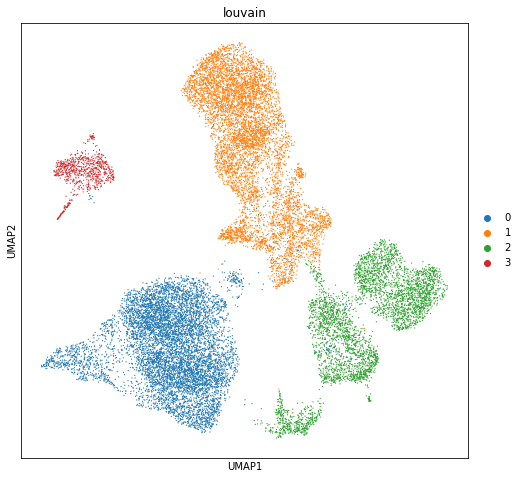

In [4]:
sc.pl.umap(SC_DF, color = 'louvain', use_raw=True)

### Subset Cardiac and adjacent clusters. Recluster using UMAP

In [41]:
sg_pos = []

for cell in SC_DF.obs.index:
    if SC_DF.obs.loc[cell].louvain == '1':
        sg_pos.append(cell)

cardiac_cells = SC_DF[sg_pos]

In [42]:
sc.tl.pca(cardiac_cells, random_state= 0)

computing PCA
    with n_comps=50
    finished (0:00:25)


In [43]:
sce.tl.phate(cardiac_cells, k= 10, a= 50, random_state = 0)

computing PHATE


Calculating PHATE...
  Running PHATE on 7884 cells and 32266 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.01 seconds.
    Calculating KNN search...
    Calculated KNN search in 7.18 seconds.
    Calculating affinities...
    Calculated affinities in 1.41 seconds.
  Calculated graph and diffusion operator in 17.67 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.70 seconds.
    Calculating KMeans...
    Calculated KMeans in 52.76 seconds.
  Calculated landmark operator in 57.22 seconds.
  Calculating optimal t...
  Calculated optimal t in 1.74 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.38 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 20.83 seconds.
Calculated PHATE in 97.85 seconds.


    finished: added
    'X_phate', PHATE coordinates (adata.obsm) (0:01:37)


In [44]:
sc.pp.neighbors(
    cardiac_cells,
    use_rep='X_pca',
    random_state = 0
)
#standard is no neighbors
#sc.tl.diffmap(adata_filtered)
#sc.pp.neighbors(adata_filtered, n_neighbors=10, use_rep='X_diffmap')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [45]:
### Cluster the neighborhood graph
#sc.tl.leiden(adata_filtered)
sc.tl.louvain(
    cardiac_cells,
    resolution = 0.7,
    random_state = 0)
#For good clustering use 0.025
#Standard use 0.4
#sc.tl.phate(adata_filtered, k=3, a=20, n_jobs=-2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)


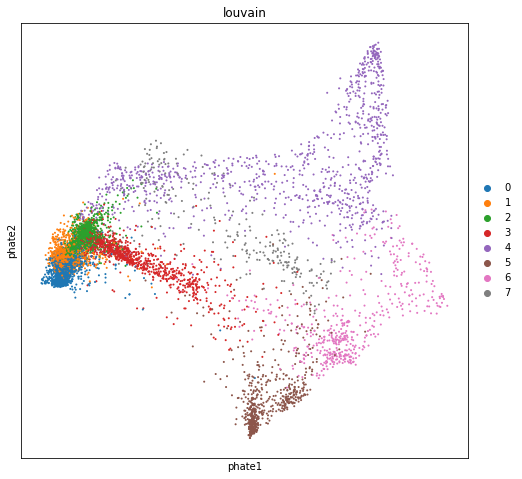

In [98]:
sce.pl.phate(cardiac_cells, color = 'louvain')

In [99]:
sc.tl.rank_genes_groups(cardiac_cells, groupby='louvain', key_added='rank_genes_r1.0')

ranking genes
    finished: added to `.uns['rank_genes_r1.0']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


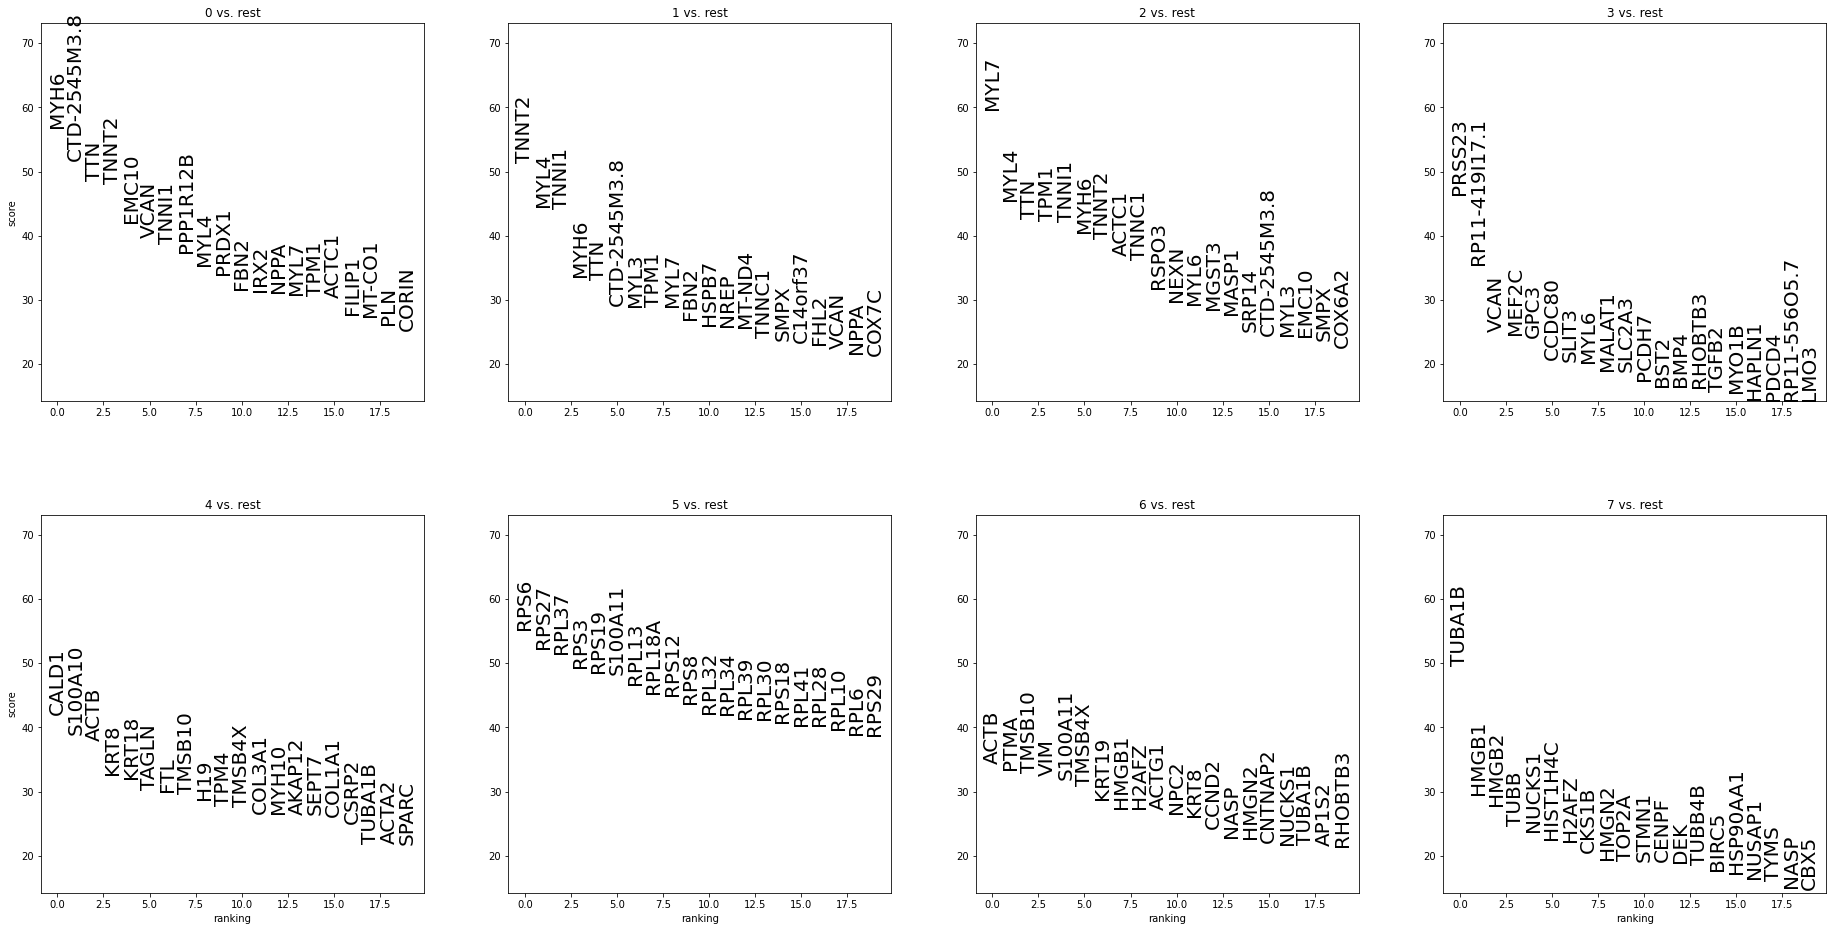

In [100]:
sc.pl.rank_genes_groups(cardiac_cells, key='rank_genes_r1.0',fontsize=20)

In [101]:
cardiac_cells.uns['iroot'] = np.flatnonzero(cardiac_cells.obs['louvain']  == '1')[0]

In [102]:
sc.tl.dpt(cardiac_cells)


computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


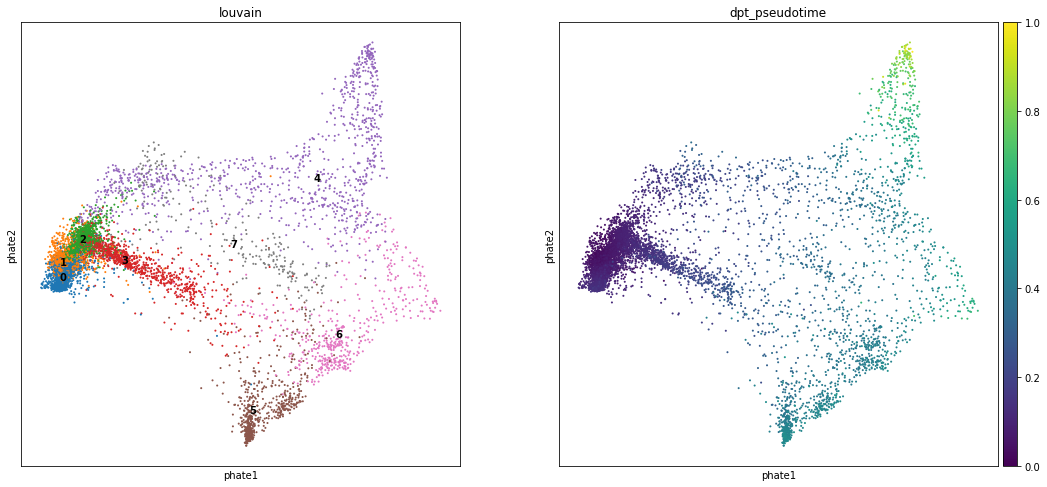

In [103]:
sce.pl.phate(cardiac_cells, color=['louvain', 'dpt_pseudotime'], legend_loc='on data')


In [104]:
# Calculate ranks of pseudotime
array = np.array(cardiac_cells.obs['dpt_pseudotime'])

temp = array.argsort()

ranks = np.empty_like(temp)

ranks[temp] = np.arange(len(array))

cardiac_cells.obs['rank_pseudotime'] = ranks

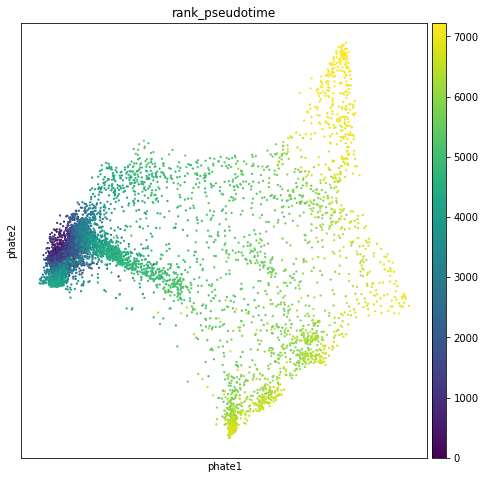

In [105]:
# Figure 4B
sce.pl.phate(cardiac_cells, color='rank_pseudotime', size=20, 
#          save='_BL41Only_rank_pseudotime.pdf'
          )

### Subset Cells and Rerun PHATE (Selected for cardiac cells)

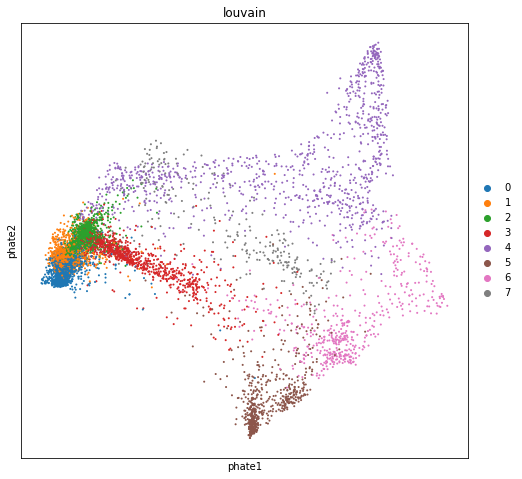

In [106]:
sce.pl.phate(cardiac_cells, color = 'louvain')

In [107]:
sg_pos = []
Interested_Cluster = ['0', '1', '2', '3']
for cell in cardiac_cells.obs.index:
    if cardiac_cells[cell].obs.louvain.tolist()[0] in Interested_Cluster:
        sg_pos.append(cell)
cardiac_cells_subset = cardiac_cells[sg_pos]

In [108]:
sc.tl.pca(cardiac_cells_subset, random_state= 0)

computing PCA
    with n_comps=50
    finished (0:00:14)


In [109]:
#sce.tl.phate(cardiac_cells, k= 50, a= 100, random_state = 0)
#sce.tl.phate(cardiac_cells, k= 60, a= 100, random_state = 0)
#sce.tl.phate(cardiac_cells, k= 60, a= 100, random_state = 0)
#sce.tl.phate(cardiac_cells, k= 200, a= 100, random_state = 0)
sce.tl.phate(cardiac_cells_subset, k=20, a= 100, random_state = 0)

computing PHATE


Calculating PHATE...
  Running PHATE on 4871 cells and 31671 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.96 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.83 seconds.
    Calculating affinities...
    Calculated affinities in 0.26 seconds.
  Calculated graph and diffusion operator in 9.09 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.61 seconds.
    Calculating KMeans...
    Calculated KMeans in 30.45 seconds.
  Calculated landmark operator in 33.63 seconds.
  Calculating optimal t...
  Calculated optimal t in 1.77 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.39 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 37.73 seconds.
Calculated PHATE in 82.64 seconds.


    finished: added
    'X_phate', PHATE coordinates (adata.obsm) (0:01:22)


In [110]:
sc.pp.neighbors(
    cardiac_cells_subset,
    use_rep='X_pca',
    random_state = 0
)
#standard is no neighbors
#sc.tl.diffmap(adata_filtered)
#sc.pp.neighbors(adata_filtered, n_neighbors=10, use_rep='X_diffmap')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [136]:
### Cluster the neighborhood graph
#sc.tl.leiden(adata_filtered)
sc.tl.louvain(
    cardiac_cells_subset,
    resolution = 1.2,
    random_state = 0)
#For good clustering use 0.025
#Standard use 0.4
#sc.tl.phate(adata_filtered, k=3, a=20, n_jobs=-2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


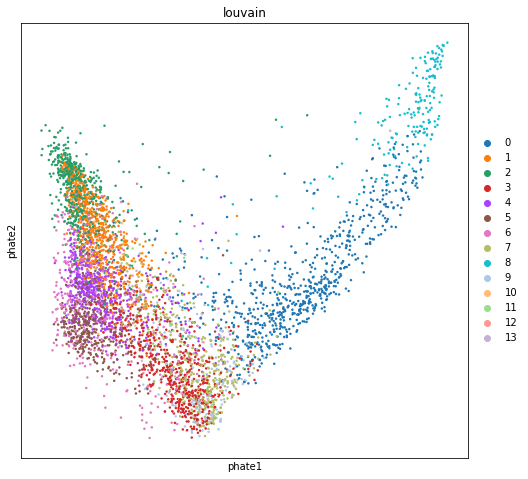

In [137]:
sce.pl.phate(cardiac_cells_subset, color = 'louvain')

In [138]:
cardiac_cells_subset.uns['iroot'] = np.flatnonzero(cardiac_cells_subset.obs['louvain']  == '8')[0]

In [139]:
sc.tl.dpt(cardiac_cells_subset)


computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [140]:
# Calculate ranks of pseudotime
array = np.array(cardiac_cells_subset.obs['dpt_pseudotime'])

temp = array.argsort()

ranks = np.empty_like(temp)

ranks[temp] = np.arange(len(array))

cardiac_cells_subset.obs['rank_pseudotime'] = ranks

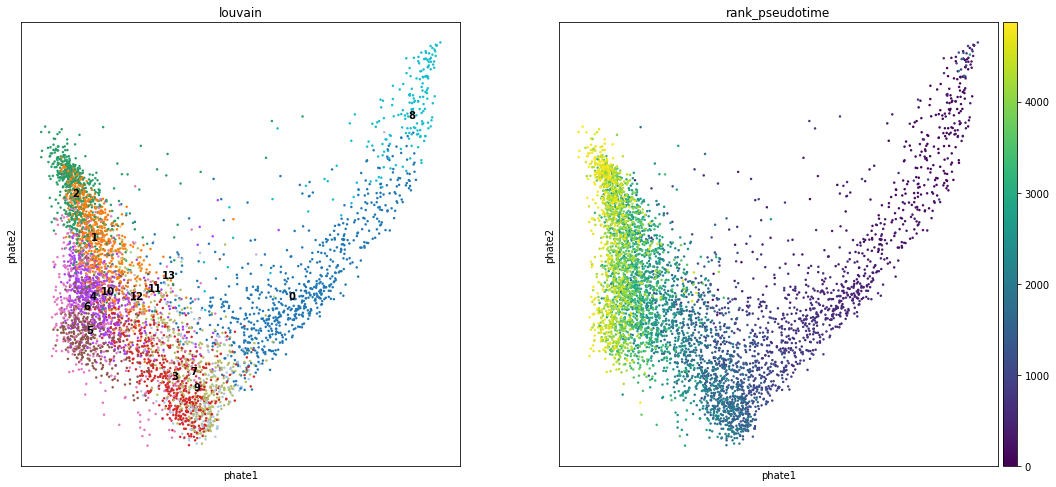

In [141]:
sce.pl.phate(cardiac_cells_subset, color=['louvain', 'rank_pseudotime'], legend_loc='on data')

In [142]:
sc.tl.rank_genes_groups(cardiac_cells_subset, groupby='louvain', key_added='broad_clusters', method = 'wilcoxon')

ranking genes
    finished: added to `.uns['broad_clusters']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


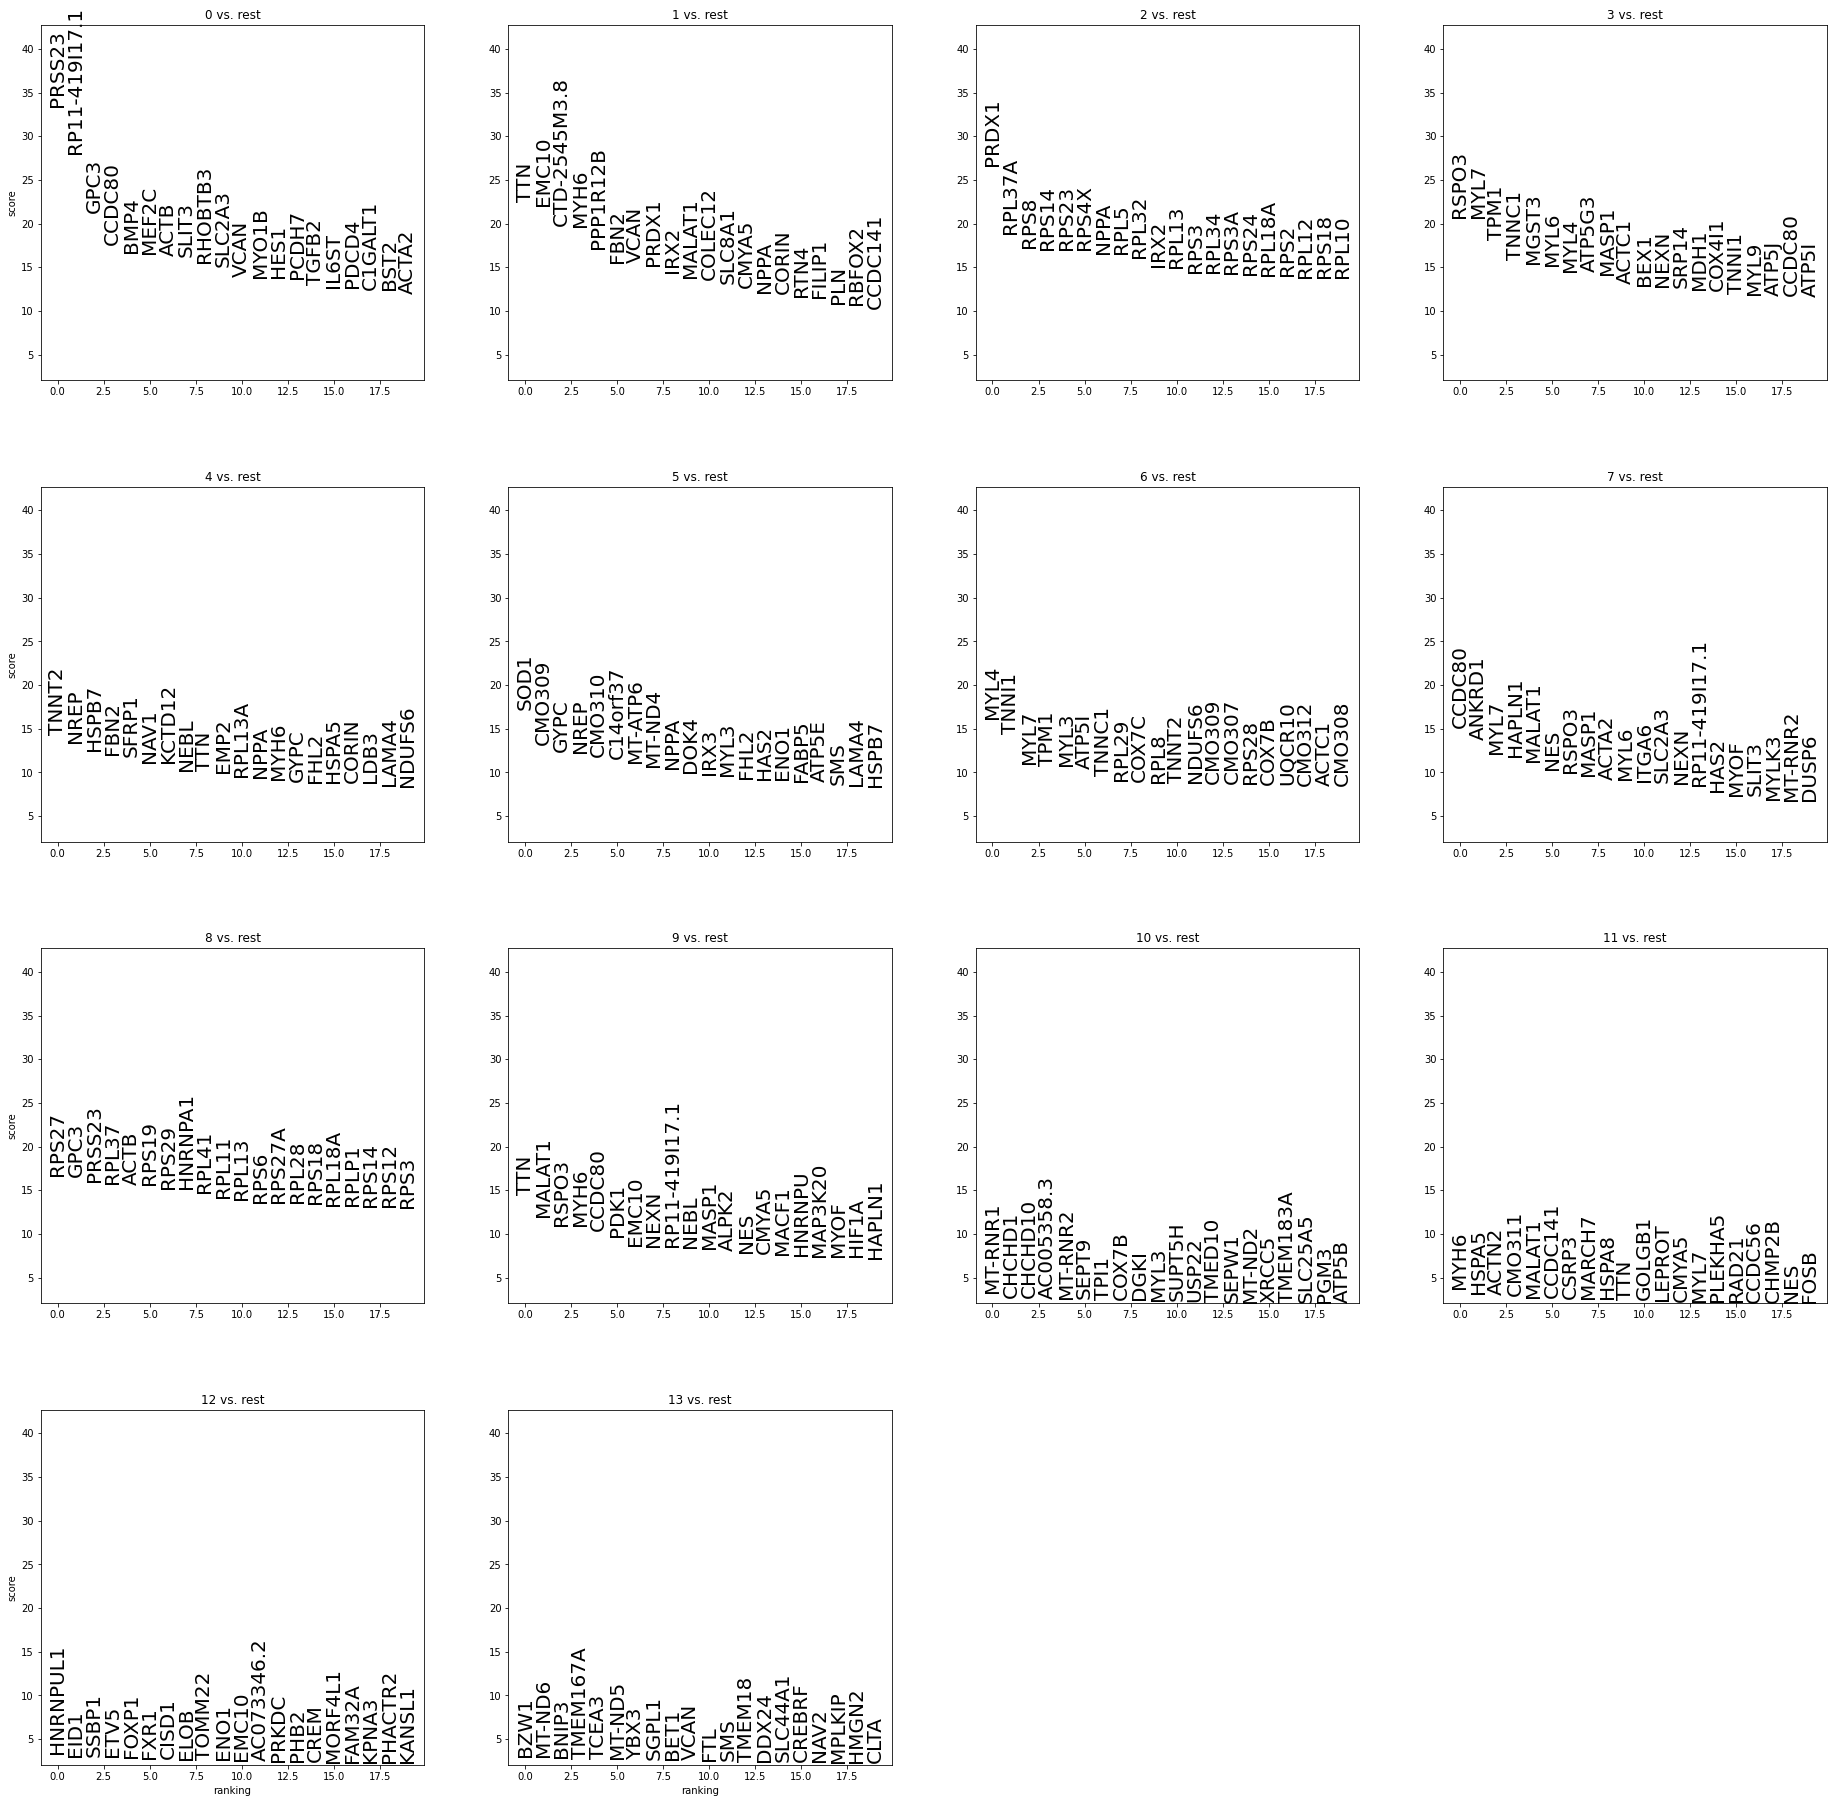

In [143]:
sc.pl.rank_genes_groups(cardiac_cells_subset, key='broad_clusters',fontsize=20)

In [144]:
### Cluster the neighborhood graph
#sc.tl.leiden(adata_filtered)
sc.tl.louvain(
    cardiac_cells_subset,
    resolution = .4,
    random_state = 0)
#For good clustering use 0.025
#Standard use 0.4
#sc.tl.phate(adata_filtered, k=3, a=20, n_jobs=-2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


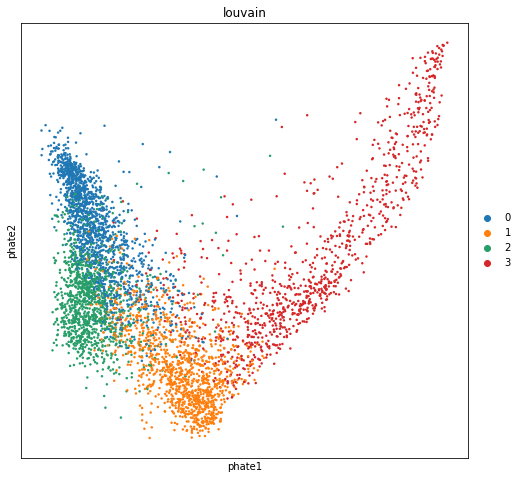

In [145]:
sce.pl.phate(cardiac_cells_subset, color = 'louvain')

In [146]:
sc.tl.rank_genes_groups(cardiac_cells_subset, groupby='louvain', key_added='rank_genes_r1.0', method = 'wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_r1.0']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


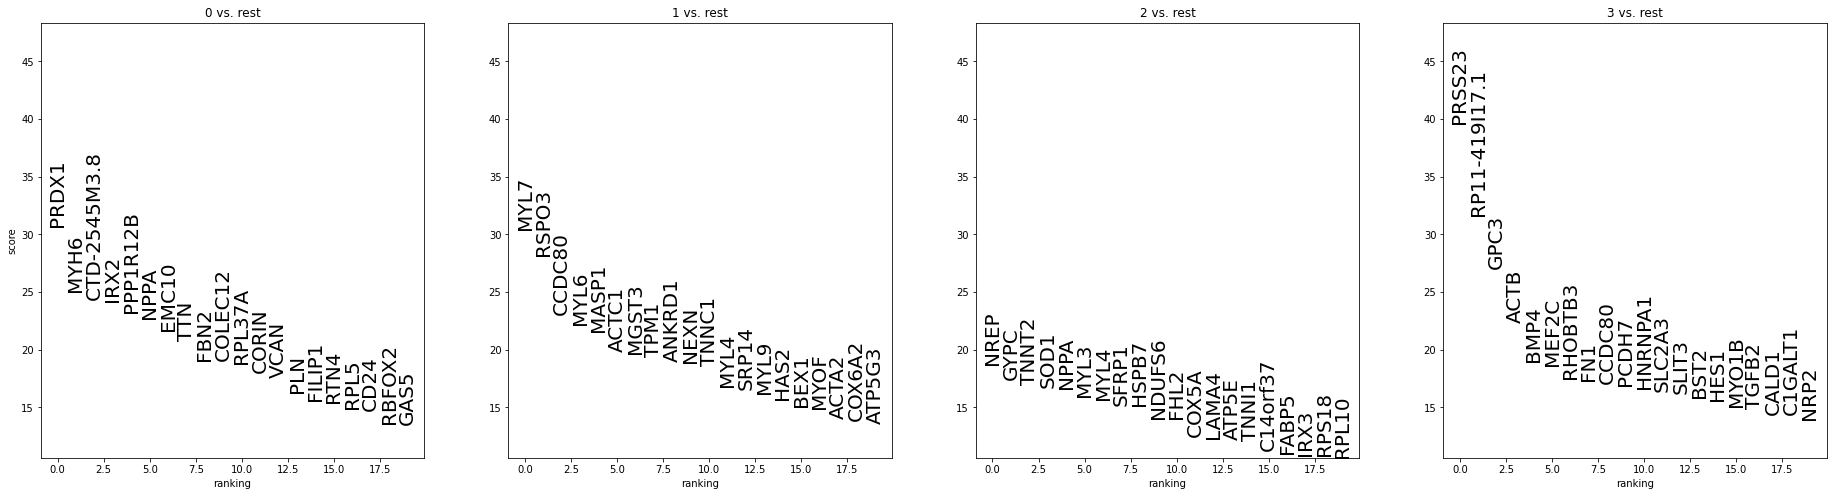

In [147]:
sc.pl.rank_genes_groups(cardiac_cells_subset, key='rank_genes_r1.0',fontsize=20)

In [148]:
Sample_List = ['WT:B1', 'ENH3:B1', 'ENH5:B1', 'WT:B2', 'ENH3:B2', 'ENH5:B2']
Sample_Col = [0,1,2,0,1,2]

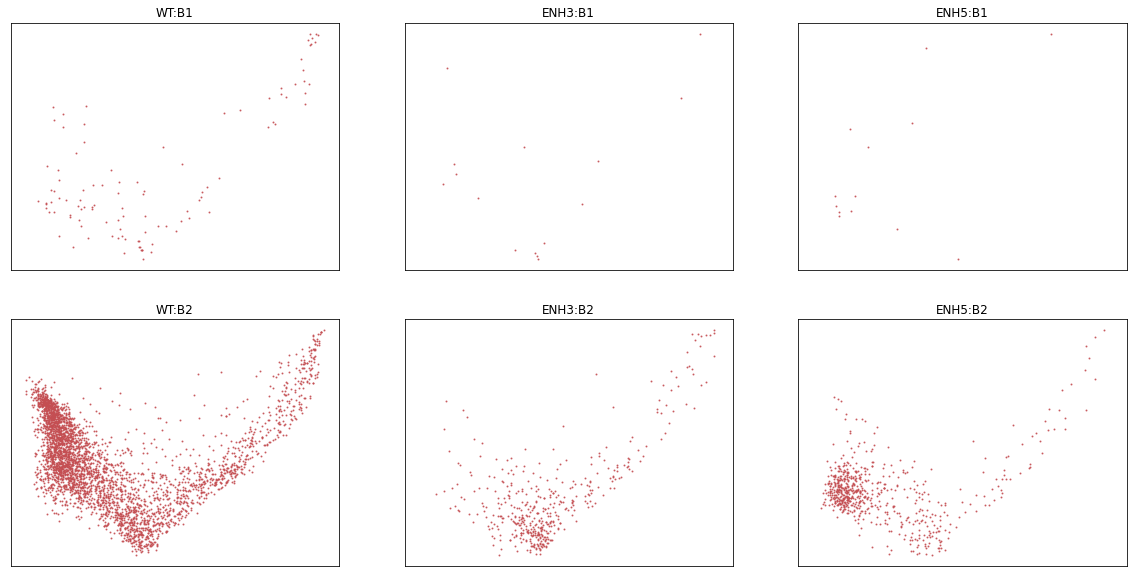

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10), sharex=True)

for i,sample in enumerate(Sample_List):
    sg_pos_cell = []
    for bc in cardiac_cells_subset.obs.index:
        if bc in cardiac_cells_subset[cardiac_cells_subset.obs['B_Reps'] == sample].obs.index:
            sg_pos_cell.append(1)
        else:
            sg_pos_cell.append(0)
    
    
    
    if sample.split(':')[1] == 'B1':
        row_set = 0
    else:
        row_set = 1
    col_set = Sample_Col[i]
        
    ax=axes[row_set,col_set]
    
    indices = np.nonzero(sg_pos_cell)[0]
    x = cardiac_cells_subset.obsm['X_phate'][indices,0]
    y = cardiac_cells_subset.obsm['X_phate'][indices,1]
    ax.scatter(x, 
               y, 
               c='#c44e52',
               s=1,
            alpha=0.8)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(sample)
    ax.grid(False)

In [ ]:
cardiac_cells_subset.write('./Knockout_CM_DF.h5ad')